# Simulating noisy data from models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import cmdstanpy

## Deterministic SIR  with log normal error

In [2]:
N = 1
I0 = 0.01
R0 = 0
S0 = (N - I0 - R0)
γ = 0.1
β = 0.9

In [51]:
def truncLN(mean, sigma,ul=1):
    '''quick and dirty truncated LogNormal'''
    yobs = np.ones(mean.shape[0])*2*ul
    while not (yobs<ul).all():
        yobs = np.random.lognormal(mean=mean, sigma=sigma)
    return yobs
    

In [42]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

times = np.arange(0, 20, 0.25)
y = odeint(SIR, t=times, y0=[S0, I0], args=((β, γ),), rtol=1e-8)
# Simulando dados  Assumindo uma distribuição log-normal com média igual às séries simuladas
# yobs = np.random.lognormal(mean=np.log(y[1:]), sigma=[0.2, 0.3])
yobs = truncLN(np.log(y),[0.2, 0.3])

In [43]:
np.save("logNSIRdata.npy",yobs)

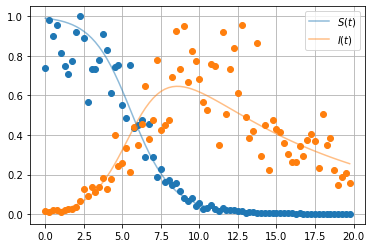

In [44]:
plt.plot(times, yobs, marker='o', linestyle='none')
plt.plot(times, y[:, 0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label=f'$I(t)$');
plt.grid()
plt.legend();

## SIR estocástico
We can generate the a stochastic trace of a SIR model from the D implementatio `sir.d`. If necessary we can modify it and recompile using the commented line below.

In [6]:
# to recompile and run:
# !dub run  --build=release --compiler=ldc2 --single sir.d
# or simply run:
!./sir_stoch  

Time of the SIR run with N=100: 253 μs and 4 hnsecs
Number of steps: 191


In [7]:
import pandas as pd

In [8]:
sim = pd.read_csv('sir_stoch.csv')
sim.set_index('t', inplace=True)
sim /= 100

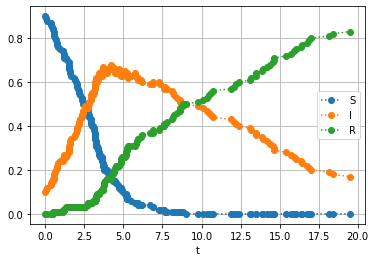

In [9]:
sim.loc[:20].plot(style=':o', grid=True);

It's important to notice that the stochastic simulation above does not yield equally spaced points in time, So it needs to be interpolated to become usable for inference.

### Gamma distribution
$$p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},$$
$$k = \frac{\mu^2}{\sigma^2}$$
$$\theta = \frac{\sigma^2}{\mu} = \frac{\mu}{k}$$

### Beta distribution
$$p(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$$
$$\alpha = \frac{\mu(1-\mu)-\sigma^{2}}{\sigma^{2}\Big(1+\frac{\sigma^{2}(1-\mu)}{\mu}\Big)}$$
$$\beta = \frac{\alpha(1-\mu)}{\mu}$$

# Alternative SIR formulation (Butcher's solver)

In [22]:
def r(R, β, γ):
    R0 = β/γ
    return γ*(N - R - S0*(np.e**(-R0*R)))

In [19]:
def A_SIR_Butcher(R, h, β, γ):
    for i in range(1, 100):
        k1 = r(R[i-1], β, γ)
        k2 = r(R[i-1] + (1/4)*k1*h, β, γ)
        k3 = r(R[i-1] + (1/8)*k1*h + (1/8)*k2*h, β, γ)
        k4 = r(R[i-1] - (1/2)*k2*h + k3*h, β, γ)
        k5 = r(R[i-1] + (3/16)*k3*h + (9/16)*k4*h, β, γ)
        k6 = r(R[i-1] - (3/7)*k1*h + (2/7)*k2*h + (12/7)*k3*h - (12/7)*k4*h + (8/7)*k5*h, β, γ)
        R[i] = R[i-1] + (1/90)*((7*k1) + (32 * k3) + (12 * k4) + (32 * k5) + (7*k6))*h
    return R

In [20]:
#Just a set rgb colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):    
    rgb = tableau20[i]    
    tableau20[i] = np.array(rgb)/255. 

In [23]:
S = [S0]*100
R = [0]*100
I = [I0]*100
drdt = np.array(A_SIR_Butcher(R, 0.5, β, γ))

$$\frac{dR}{dt} = \gamma(N - R - S_{0}e^{-\mathfrak{R}_{0}R})$$

In [25]:
#error
# σ = np.random.lognormal(-1, 1)
ϵ = np.random.uniform(-1,1)

In [26]:
y = drdt*np.exp(ϵ)

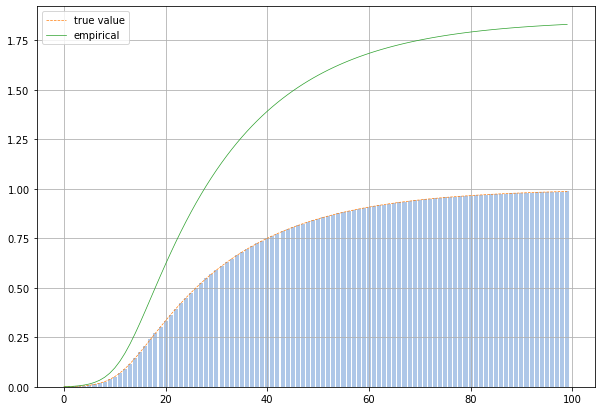

In [32]:
plt.figure(figsize=(10,7))
plt.bar(list(range(100)), drdt, color=tableau20[1])
plt.plot(list(range(100)), drdt, '--', color=tableau20[2], linewidth=0.7, label='true value')
plt.plot(list(range(100)), y, '-', color=tableau20[4], linewidth=0.7, label='empirical')
plt.legend()
plt.grid()
plt.savefig("R_randb.png")

In [28]:
np.savetxt("y.csv", y, delimiter=",")

## Simulating with Runge-Kutta
We will load the implementation from epimodels.

In [64]:
def SIR1D(y,t,R0,gamma,S0):
    N = 100
    R = y[0]
#     R0, gamma, S0 = p[0],p[1],p[2]
    return [
        gamma * (N - R - (S0 * np.exp(-R0 * R)))
    ]
inits = [1]
trange = np.arange(0,20,.25)
N = 100

In [65]:
y = odeint(SIR1D,inits,trange,args=(2, 0.1, 98))

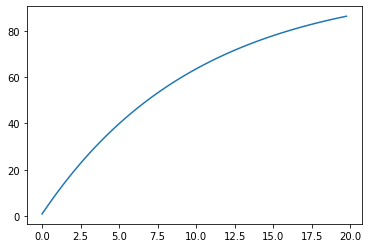

In [67]:
plt.plot(trange,y)

In [68]:
robs = truncLN(np.log(y), .2, ul=100)
np.save('robs.npy',robs)
robs

array([[ 0.75005483],
       [ 4.16640034],
       [ 4.98563432],
       [11.19348282],
       [11.36546303],
       [12.41274614],
       [16.61718089],
       [18.96076237],
       [25.30720005],
       [17.81999738],
       [23.59055366],
       [21.93448456],
       [24.93887392],
       [26.93858817],
       [26.24124902],
       [38.15044477],
       [37.66281589],
       [32.3698292 ],
       [29.06298423],
       [35.28735432],
       [39.42861728],
       [33.55568384],
       [34.0634545 ],
       [37.83895102],
       [34.93176809],
       [38.54249481],
       [45.4627252 ],
       [54.27916055],
       [49.15672798],
       [48.44904919],
       [46.90859741],
       [63.71568463],
       [53.06468548],
       [57.61968248],
       [40.14920725],
       [47.17881795],
       [80.91848282],
       [59.3357722 ],
       [70.09910344],
       [63.01919669],
       [54.885657  ],
       [78.00328421],
       [67.07410771],
       [71.06456858],
       [53.28599561],
       [88

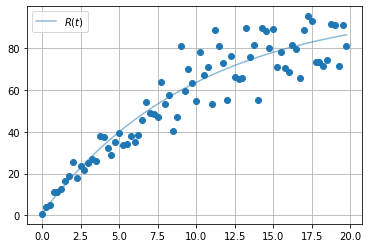

In [69]:
plt.plot(trange, robs, marker='o', linestyle='none')
plt.plot(trange, y, color='C0', alpha=0.5, label=f'$R(t)$')
plt.grid()
plt.legend();